In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB

%matplotlib inline
sns.set_style('white')

In [2]:
raw = pd.read_csv('yelp_labelled.txt', sep='\t', names=['comment','sentiment'])

In [3]:
raw.head(10)

,comment,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


In [4]:
keywords = ['great', 'good', 'delight','wow', 'like', 'love', 'beautiful']

for key in keywords:
    raw[str(key)] = raw.comment.str.contains(str(key), case=False)

In [5]:
raw.sentiment.replace([0, 1], [False, True], inplace=True)

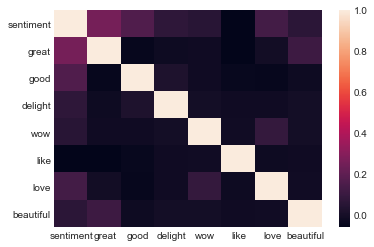

In [6]:
corrmat = raw.corr()
sns.heatmap(corrmat)
plt.show()

In [7]:
data = raw[keywords]
target = raw['sentiment']

In [8]:
bnb = BernoulliNB()

bnb.fit(data, target)

y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 362


First attempt: 362/1000 incorrect. That's bad news. I need a better idea of which words are important.

In [9]:
#Let's find which words are most typical for good and bad reviews

import string

translator = str.maketrans('', '', string.punctuation)
pos_words = pd.Series()
neg_words = pd.Series()

for com in raw[raw.sentiment==1].comment:
    words = com.split(' ')
    for w in words:
        s = w.translate(translator).lower()
        pos_words = pos_words.append(pd.Series(s), ignore_index=True)
        
for com in raw[raw.sentiment==0].comment:
    words = com.split(' ')
    for w in words:
        s = w.translate(translator).lower()
        neg_words = neg_words.append(pd.Series(s), ignore_index=True)

In [10]:
#And now exclude the words in common between the two sets

keywords = []
for word in pos_words.value_counts().head(100).index:
    if not np.isin(word, neg_words.value_counts().head(100).index): keywords.append(str(word)) 

In [11]:
keywords

['great',
 'friendly',
 'delicious',
 'best',
 'nice',
 'amazing',
 'also',
 'restaurant',
 'love',
 'vegas',
 'staff',
 'first',
 'fantastic',
 'menu',
 'experience',
 'always',
 'awesome',
 'made',
 'its',
 'pretty',
 'he',
 'loved',
 'definitely',
 'perfect',
 'steak',
 'excellent',
 'fresh',
 'pizza',
 'even',
 'atmosphere',
 'prices',
 'chicken',
 'server',
 'has',
 'tasty',
 'every',
 'well']

This list of words is way better than mine! Let's try the model with these.

In [12]:
raw = pd.read_csv('yelp_labelled.txt', sep='\t', names=['comment','sentiment'])
raw.sentiment.replace([0, 1], [False, True], inplace=True)

for key in keywords:
    raw[str(key)] = raw.comment.str.contains(str(key), case=False)
    
data = raw[keywords]
target = raw['sentiment']


bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 267


Okay, it's a little better: 267/1000 mislabeled. Maybe negative words are more predictive than positive? Let's try updating 'keywords' to reflect that.

In [13]:
keywords = []
for word in neg_words.value_counts().head(100).index:
    if not np.isin(word, pos_words.value_counts().head(100).index): keywords.append(str(word)) 

In [14]:
raw = pd.read_csv('yelp_labelled.txt', sep='\t', names=['comment','sentiment'])
raw.sentiment.replace([0, 1], [False, True], inplace=True)
raw.sentiment = raw.sentiment == False

for key in keywords:
    raw[str(key)] = raw.comment.str.contains(str(key), case=False)
    
data = raw[keywords]
target = raw['sentiment']


bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 275


Well, that's actually about the same. So we're hovering around 27% error rate. I can increase the number of words in each set, which gets us down to about 20%. Increasing this too much risks overfitting. Let's see how these keywords generalize to another dataset. We'll switch back to positive reviews. (Note: This dataset had very SHORT reviews)

In [15]:
keywords = []
for word in pos_words.value_counts().head(100).index:
    if not np.isin(word, neg_words.value_counts().head(100).index): keywords.append(str(word)) 

In [16]:
raw_imdb = pd.read_csv('imdb_labelled.txt', sep='\t', names=['comment','sentiment'])
raw_imdb.sentiment.replace([0, 1], [False, True], inplace=True)

for key in keywords:
    raw_imdb[str(key)] = raw_imdb.comment.str.contains(str(key), case=False)
    
data = raw_imdb[keywords]
target = raw_imdb['sentiment']


bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 748 points : 288


So: 288/748 labelled incorrectly. It's not that good. Fair enough. Food words are probably different than movie words.